### The Integral Model

Wilson-Cowan-Amari neural field equation:

$$\frac{\partial u(x,t)}{\partial t} = - u(x,t) + \int_{-L}^{L} W(x,y)f(u(y, t)) dy$$

where $u(x,t)$ is the synaptic potential, $W(x,y)$ the synaptic connectivity and $f(u)$ a nonlinear function for the conversion of the synaptic potential into a firing rate. In general, both $W$ and $f$ depend upon control parameters which we will define later.

$$ W(x,y) = w(|x-y|)\\$$ with

### Choices for the Connectivity Kernel and Firing Rate Function:

The Connectivity Kernel and Firing Rate Function are objects that receive the Parameters on their Constructors and can be evaluated using the () operator.

They are defined as:

Connectivity Kernel1: 

$$ W(x;b) = \frac{1}{2} e^{-b|x|}\\$$
Connectivity Kernel2:

$$ W(x; b) = e^{-b|x|}(b \sin{|x|} + \cos{x}) \\$$
Here, $b$ controls the decay of the Synaptic Kernel.

Firing Rate1:

$$ f(u; \mu, \theta) = \frac{1}{1+exp(-\mu(u-\theta))} \\$$
Firing Rate2:

$$ f(u; \mu, \theta) = \frac{1}{1+e^{-\mu u + \theta}} - \frac{1}{1+e^\theta}\\$$
Here, $\mu$ controls the slope of the sigmoidal firing rate, and $\theta$ is a threshold value.

In [1]:
from math import *
import numpy as np
from scipy.integrate import ode
import FiringRate as fr
import ConnectivityKernel as ck
import NeuralField as nf
import matplotlib.pyplot as pt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
# Spatial Grid
nx = (2**10)-1 # Number of points in the space grid
Lx = 30 # Space grid limits
hx = 2*Lx/nx # Space width between points in the grid 
x = np.linspace(-Lx, Lx-hx, nx) # nx equally spaced points between -Lx and Lx-hx

In [3]:
# Initialize Connectivity Kernel Object
b = 0.4
kernel = ck.ConnectivityKernel2(b)

Plot the Chosen Connectivity Kernel

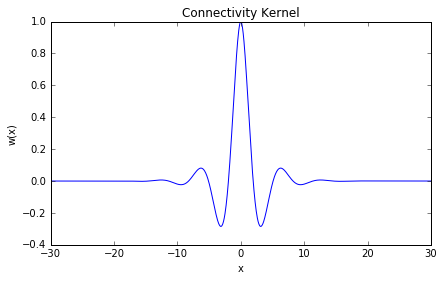

In [4]:
plot_kernel = True
if(plot_kernel):
    fig1 = pt.figure(figsize=(15,4))

    ax1 = fig1.add_subplot(121)
    ax1.plot(x, kernel(x))
    ax1.set_title('Connectivity Kernel')
    ax1.set_xlabel('x')
    ax1.set_ylabel('w(x)')

Discretized Neural Field Equation
$$\dot{u_i}(t) = -u_i(t) + \sum_j w(|x_i-y_j|)f(u_i(t)) \rho_j$$

where:

$\{x_i\}, x_i \in [-L, L] \hspace{5mm} \forall i\\
\{y_j\}, y_j \in [-L, L] \hspace{5mm} \forall j\\
\rho(j) \hspace{5mm} \text{are the quadrature weights} $

In [5]:
# Quadrature weights for Composite trapezoidal
rho = np.ones(x.size)
rho = rho*hx

### A small test for the Quadrature rule

In [6]:
def f(x):
    return x**2

S=0
for i, point in enumerate(x):
    S += rho[i]*f(point)
    
print("Result = "+str(S))
print("Error = " + str((18000) - S))

Result = 18000.0343994
Error = -0.0343994289578


Nyström Method: Let $\{x_i\} = \{y_j\}$

In [7]:
# Assemble the Synaptic Matrix W
W = np.zeros((nx, nx))
for i in range(nx):
    for j in range(nx):
        W[i,j] = rho[j]*kernel(x[i]-x[j])

Discretized Neural Field Equation
$$\underline{\dot{\textbf{u}}} = - \underline{\textbf{u}} + \underline{\underline{\textbf{W}}} \space f (\underline{\textbf{u}})$$

In [12]:
# Initialize Firing Rate and Nerual Field objects.
mu = 3.5
theta = 3.5
f = fr.FiringRate2(mu, theta)

neural_field = nf.NeuralField(f, W)

### Use Standard ODE Solvers

In [13]:
#Initial Conditions
A0 = 10; alpha = 0.1 # Parameters of Initial Conditions Function
initCond = lambda x_vec: A0/(np.cosh(alpha*x_vec)**2)
u0 = initCond(x)

In [14]:
# Time step using RungeKutta4
method = ode(neural_field).set_integrator("dopri5")
method.set_initial_value(u0)
final_t = 60
dt = 0.1
ts = [] 
us = []
while method.t < final_t:
    next_t = method.t+dt
    ts.append(next_t)
    next_u = method.integrate(next_t)
    us.append(next_u)
us = np.array(us)
ts = np.array(ts)

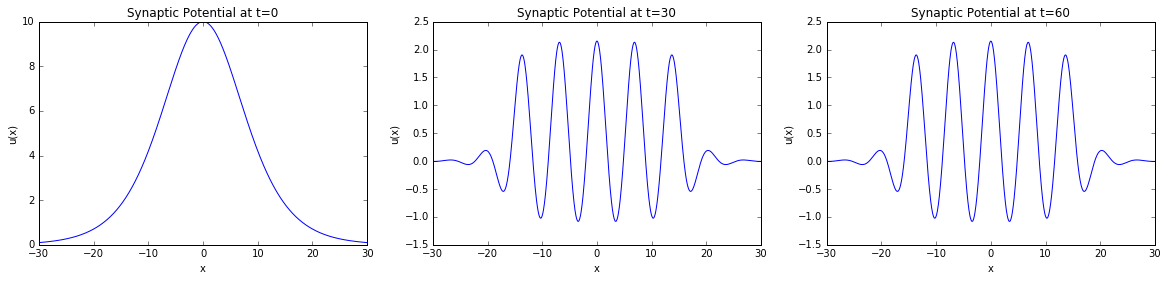

In [15]:
#Plot
fig2 = pt.figure(figsize=(20,4))

ax1 = fig2.add_subplot(131)
ax1.plot(x, u0)
ax1.set_title('Synaptic Potential at t=0')
ax1.set_xlabel('x')
ax1.set_ylabel('u(x)')

ax2 = fig2.add_subplot(132)
ax2.plot(x, us[int((final_t/dt)/2)])
ax2.set_title('Synaptic Potential at t='+str(int(final_t/2)))
ax2.set_xlabel('x')
ax2.set_ylabel('u(x)')

ax3 = fig2.add_subplot(133)
ax3.plot(x, us[-1])
ax3.set_title('Synaptic Potential at t='+str(final_t))
ax3.set_xlabel('x')
ax3.set_ylabel('u(x)')

#pt.savefig("mu=("+str(miu)+").png")